In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import sys
import random
import joblib
import json 

import numpy as np
import pandas as pd
import sklearn
import umap
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from types import SimpleNamespace
from collections import Counter

import torch
import torch.nn.functional as F
from torch import nn, optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# PAX4

In [40]:
base_dir = "/data/gl/g2/sachit/data/veres/perturbations/2_400_kegg_001500_seed_1_real/islet_cells2/prog_sox2/"
filenames=os.listdir(base_dir)

In [41]:
filenames.sort()

In [42]:
filenames

['ARX_0_over.pt',
 'ARX_1_over.pt',
 'ARX_1_under.pt',
 'ARX_2_over.pt',
 'ISL1_0_over.pt',
 'ISL1_1_over.pt',
 'ISL1_1_under.pt',
 'ISL1_2_over.pt',
 'MAFA_0_over.pt',
 'MAFA_1_over.pt',
 'MAFA_1_under.pt',
 'MAFA_2_over.pt',
 'MAFB_0_over.pt',
 'MAFB_1_over.pt',
 'MAFB_1_under.pt',
 'MAFB_2_over.pt',
 'NEUROD1_0_over.pt',
 'NEUROD1_1_over.pt',
 'NEUROD1_1_under.pt',
 'NEUROD1_2_over.pt',
 'NKX2-2_0_over.pt',
 'NKX2-2_1_over.pt',
 'NKX2-2_1_under.pt',
 'NKX2-2_2_over.pt',
 'NKX6-1_0_over.pt',
 'NKX6-1_1_over.pt',
 'NKX6-1_1_under.pt',
 'NKX6-1_2_over.pt',
 'PAX4_0_over.pt',
 'PAX4_1_over.pt',
 'PAX4_1_under.pt',
 'PAX4_2_over.pt',
 'PAX6_0_over.pt',
 'PAX6_1_over.pt',
 'PAX6_1_under.pt',
 'PAX6_2_over.pt',
 'PDX1_0_over.pt',
 'PDX1_1_over.pt',
 'PDX1_1_under.pt',
 'PDX1_2_over.pt',
 'alpha_cell_ensemble_0_over.pt',
 'alpha_cell_ensemble_1_over.pt',
 'alpha_cell_ensemble_2_over.pt',
 'beta_cell_ensemble_0_over.pt',
 'beta_cell_ensemble_1_over.pt',
 'beta_cell_ensemble_2_over.pt']

In [43]:
filenames=[filenames[28], filenames[29], filenames[31]]

In [44]:
filenames

['PAX4_0_over.pt', 'PAX4_1_over.pt', 'PAX4_2_over.pt']

In [45]:
genes=[]
for name in filenames:
    genes.append(str(name).split("_")[0])
genes=np.unique(genes)

In [46]:
all_results = []
for elt in filenames:
    if elt != "std.pt":
        results=torch.load(base_dir+str(elt))
        all_results.append(results)

In [47]:
all_results[1]["perturbed_genes"]

'PAX4'

In [48]:
beta_dist = []
ec_dist = []
alpha_dist = []
for results in all_results:
    beta_counts_std = []
    for labs in results["unperturbed_labs"]:
        beta_counts_std.append(Counter(labs[-1])["sc_beta"]/200)

    beta_counts_perturb = []
    for labs in results["perturbed_labs"]:
        beta_counts_perturb.append(Counter(labs[-1])["sc_beta"]/200)
    
    ec_counts_std = []
    for labs in results["unperturbed_labs"]:
        ec_counts_std.append(Counter(labs[-1])["sc_ec"]/200)

    ec_counts_perturb = []
    for labs in results["perturbed_labs"]:
        ec_counts_perturb.append(Counter(labs[-1])["sc_ec"]/200)
    
    alpha_counts_std = []
    for labs in results["unperturbed_labs"]:
        alpha_counts_std.append(Counter(labs[-1])["sc_alpha"]/200)

    alpha_counts_perturb = []
    for labs in results["perturbed_labs"]:
        alpha_counts_perturb.append(Counter(labs[-1])["sc_alpha"]/200)
        
    beta_dist.append(np.array([beta_counts_std, beta_counts_perturb]))
    ec_dist.append(np.array([ec_counts_std, ec_counts_perturb]))
    alpha_dist.append(np.array([alpha_counts_std, alpha_counts_perturb]))
    

In [49]:
test=np.array(beta_dist)

In [50]:
unpert_average=np.concatenate(test[:,0],axis=0)

In [51]:
beta_dist[0][1]

array([0.07 , 0.025, 0.06 , 0.075, 0.055, 0.07 , 0.07 , 0.035, 0.075,
       0.07 ])

In [52]:
beta_dist_all =[]
for i in range(0,len(filenames), 3):
    print(i)
    beta_dist_norm = [unpert_average]
    for _ in range(1):
        beta_dist_norm.append(beta_dist[i][1])
        beta_dist_norm.append(beta_dist[i+1][1])
        beta_dist_norm.append(beta_dist[i+2][1])
    beta_dist_all.append(beta_dist_norm)

0


0.03574085072446724
0.014166666666666668
0.00016921714651149116
0.03416666666666667
2.244727455256512e-06
0.04966666666666667


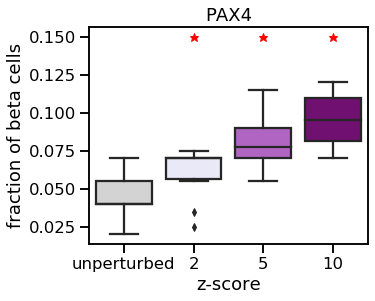

In [53]:
fig, ax = plt.subplots(figsize=(5,4), sharex=True, sharey=True)
sns.set_context("talk")
mypal=["lightgrey","lavender", "mediumorchid", "purple"]
#mypal=["lightgrey","mistyrose", "crimson", "maroon"]
ax.title.set_text(all_results[1]["perturbed_genes"])
#ax.set_ylim(0.0,0.5)
for j in range(1, 4):
    #stat, p = scipy.stats.mannwhitneyu(neu_dist_all[i][0], neu_dist_all[i][j], alternative="greater")
    stat, p = scipy.stats.ttest_ind(beta_dist_all[i][0], beta_dist_all[i][j],equal_var=False)
    print(p)
    print(np.average(beta_dist_all[i][j])-np.average(beta_dist_all[i][0]))
    x1, x2 = 0,j
    if p < .05:
        y=.15
        ax.plot(x2, y, "*", c="r")
box=sns.boxplot(data=np.array(beta_dist_all[i]).T, ax=ax, palette=mypal)
box.set_xticklabels(["unperturbed", "2", "5", "10"])
box.set_ylabel("fraction of beta cells")
ax.set_xlabel("z-score")
plt.show()

In [54]:
test=np.array(alpha_dist)

In [55]:
unpert_average=np.concatenate(test[:,0],axis=0)

In [56]:
alpha_dist_all =[]
for i in range(1):
    alpha_dist_norm = [unpert_average]
    for _ in range(1):
        alpha_dist_norm.append(alpha_dist[i][1])
        alpha_dist_norm.append(alpha_dist[i+1][1])
        alpha_dist_norm.append(alpha_dist[i+2][1])
    alpha_dist_all.append(alpha_dist_norm)

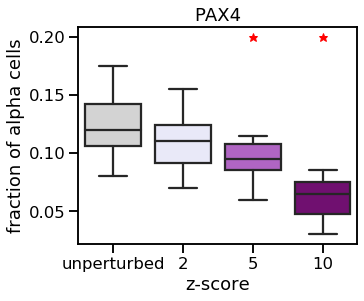

In [57]:
fig, ax = plt.subplots(figsize=(5,4), sharex=True, sharey=True)#len(filenames)/3, figsize=(10,20))
sns.set_context("talk")
sns.set_style("white")
mypal=["lightgrey","lavender", "mediumorchid", "purple"]
#mypal=["lightgrey","mistyrose", "crimson", "maroon"]
ax.title.set_text(all_results[1]["perturbed_genes"])
#ax.set_ylim(0.0,0.6)
for j in range(1, 4):
    #stat, p = scipy.stats.mannwhitneyu(neu_dist_all[i][0], neu_dist_all[i][j], alternative="greater")
    stat, p = scipy.stats.ttest_ind(alpha_dist_all[i][0], alpha_dist_all[i][j],equal_var=False)
    x1, x2 = 0,j
    if p < .05:
        y=.2
        ax.plot(x2, y, "*", c="r")
box=sns.boxplot(data=np.array(alpha_dist_all[i]).T, ax=ax, palette=mypal)
box.set_xticklabels(["unperturbed", "2", "5", "10"])
box.set_ylabel("fraction of alpha cells")
ax.set_xlabel("z-score")
plt.show()

# ARX

In [58]:
base_dir = "/data/gl/g2/sachit/data/veres/perturbations/2_400_kegg_001500_seed_1_real/islet_cells2/prog_sox2/"
filenames=os.listdir(base_dir)

In [59]:
filenames.sort()

In [60]:
filenames

['ARX_0_over.pt',
 'ARX_1_over.pt',
 'ARX_1_under.pt',
 'ARX_2_over.pt',
 'ISL1_0_over.pt',
 'ISL1_1_over.pt',
 'ISL1_1_under.pt',
 'ISL1_2_over.pt',
 'MAFA_0_over.pt',
 'MAFA_1_over.pt',
 'MAFA_1_under.pt',
 'MAFA_2_over.pt',
 'MAFB_0_over.pt',
 'MAFB_1_over.pt',
 'MAFB_1_under.pt',
 'MAFB_2_over.pt',
 'NEUROD1_0_over.pt',
 'NEUROD1_1_over.pt',
 'NEUROD1_1_under.pt',
 'NEUROD1_2_over.pt',
 'NKX2-2_0_over.pt',
 'NKX2-2_1_over.pt',
 'NKX2-2_1_under.pt',
 'NKX2-2_2_over.pt',
 'NKX6-1_0_over.pt',
 'NKX6-1_1_over.pt',
 'NKX6-1_1_under.pt',
 'NKX6-1_2_over.pt',
 'PAX4_0_over.pt',
 'PAX4_1_over.pt',
 'PAX4_1_under.pt',
 'PAX4_2_over.pt',
 'PAX6_0_over.pt',
 'PAX6_1_over.pt',
 'PAX6_1_under.pt',
 'PAX6_2_over.pt',
 'PDX1_0_over.pt',
 'PDX1_1_over.pt',
 'PDX1_1_under.pt',
 'PDX1_2_over.pt',
 'alpha_cell_ensemble_0_over.pt',
 'alpha_cell_ensemble_1_over.pt',
 'alpha_cell_ensemble_2_over.pt',
 'beta_cell_ensemble_0_over.pt',
 'beta_cell_ensemble_1_over.pt',
 'beta_cell_ensemble_2_over.pt']

In [61]:
filenames=[filenames[0], filenames[1], filenames[3]]

In [62]:
filenames

['ARX_0_over.pt', 'ARX_1_over.pt', 'ARX_2_over.pt']

In [63]:
genes=[]
for name in filenames:
    genes.append(str(name).split("_")[0])
genes=np.unique(genes)

In [64]:
all_results = []
for elt in filenames:
    if elt != "std.pt":
        results=torch.load(base_dir+str(elt))
        all_results.append(results)

In [65]:
all_results[1]["perturbed_genes"]

'ARX'

In [66]:
beta_dist = []
ec_dist = []
alpha_dist = []
for results in all_results:
    beta_counts_std = []
    for labs in results["unperturbed_labs"]:
        beta_counts_std.append(Counter(labs[-1])["sc_beta"]/200)

    beta_counts_perturb = []
    for labs in results["perturbed_labs"]:
        beta_counts_perturb.append(Counter(labs[-1])["sc_beta"]/200)
    
    ec_counts_std = []
    for labs in results["unperturbed_labs"]:
        ec_counts_std.append(Counter(labs[-1])["sc_ec"]/200)

    ec_counts_perturb = []
    for labs in results["perturbed_labs"]:
        ec_counts_perturb.append(Counter(labs[-1])["sc_ec"]/200)
    
    alpha_counts_std = []
    for labs in results["unperturbed_labs"]:
        alpha_counts_std.append(Counter(labs[-1])["sc_alpha"]/200)

    alpha_counts_perturb = []
    for labs in results["perturbed_labs"]:
        alpha_counts_perturb.append(Counter(labs[-1])["sc_alpha"]/200)
        
    beta_dist.append(np.array([beta_counts_std, beta_counts_perturb]))
    ec_dist.append(np.array([ec_counts_std, ec_counts_perturb]))
    alpha_dist.append(np.array([alpha_counts_std, alpha_counts_perturb]))
    

In [67]:
test=np.array(beta_dist)

In [68]:
unpert_average=np.concatenate(test[:,0],axis=0)

In [69]:
beta_dist[0][1]

array([0.045, 0.03 , 0.04 , 0.05 , 0.04 , 0.065, 0.03 , 0.035, 0.04 ,
       0.035])

In [70]:
beta_dist_all =[]
for i in range(0,len(filenames), 3):
    print(i)
    beta_dist_norm = [unpert_average]
    for _ in range(1):
        beta_dist_norm.append(beta_dist[i][1])
        beta_dist_norm.append(beta_dist[i+1][1])
        beta_dist_norm.append(beta_dist[i+2][1])
    beta_dist_all.append(beta_dist_norm)

0


0.28352556382059046
-0.004666666666666666
3.8673627245167805e-07
-0.023666666666666662
3.8134002461794854e-12
-0.03716666666666666


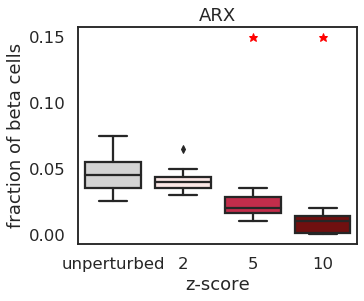

In [71]:
fig, ax = plt.subplots(figsize=(5,4), sharex=True, sharey=True)
sns.set_context("talk")
mypal=["lightgrey","mistyrose", "crimson", "maroon"]
ax.title.set_text(all_results[1]["perturbed_genes"])
#ax.set_ylim(0.0,0.5)
for j in range(1, 4):
    #stat, p = scipy.stats.mannwhitneyu(neu_dist_all[i][0], neu_dist_all[i][j], alternative="greater")
    stat, p = scipy.stats.ttest_ind(beta_dist_all[i][0], beta_dist_all[i][j],equal_var=False)
    print(p)
    print(np.average(beta_dist_all[i][j])-np.average(beta_dist_all[i][0]))
    x1, x2 = 0,j
    if p < .05:
        y=.15
        ax.plot(x2, y, "*", c="r")
box=sns.boxplot(data=np.array(beta_dist_all[i]).T, ax=ax, palette=mypal)
box.set_xticklabels(["unperturbed", "2", "5", "10"])
box.set_ylabel("fraction of beta cells")
ax.set_xlabel("z-score")
plt.show()

In [72]:
test=np.array(alpha_dist)

In [73]:
unpert_average=np.concatenate(test[:,0],axis=0)

In [74]:
alpha_dist_all =[]
for i in range(1):
    alpha_dist_norm = [unpert_average]
    for _ in range(1):
        alpha_dist_norm.append(alpha_dist[i][1])
        alpha_dist_norm.append(alpha_dist[i+1][1])
        alpha_dist_norm.append(alpha_dist[i+2][1])
    alpha_dist_all.append(alpha_dist_norm)

4.418847689135718e-05
-0.004666666666666666
5.952675681913151e-08
-0.023666666666666662
8.782293468632024e-12
-0.03716666666666666


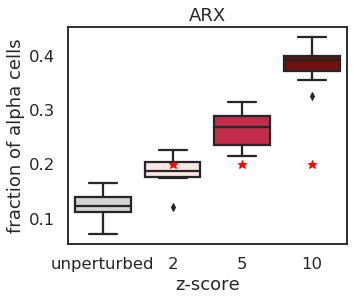

In [75]:
fig, ax = plt.subplots(figsize=(5,4), sharex=True, sharey=True)#len(filenames)/3, figsize=(10,20))
sns.set_context("talk")
sns.set_style("white")

mypal=["lightgrey","mistyrose", "crimson", "maroon"]
ax.title.set_text(all_results[1]["perturbed_genes"])
#ax.set_ylim(0.0,0.6)
for j in range(1, 4):
    #stat, p = scipy.stats.mannwhitneyu(neu_dist_all[i][0], neu_dist_all[i][j], alternative="greater")
    stat, p = scipy.stats.ttest_ind(alpha_dist_all[i][0], alpha_dist_all[i][j],equal_var=False)
    print(p)
    print(np.average(beta_dist_all[i][j])-np.average(beta_dist_all[i][0]))
    x1, x2 = 0,j
    if p < .05:
        y=.2
        ax.plot(x2, y, "*", c="r")
box=sns.boxplot(data=np.array(alpha_dist_all[i]).T, ax=ax, palette=mypal)
box.set_xticklabels(["unperturbed", "2", "5", "10"])
box.set_ylabel("fraction of alpha cells")
ax.set_xlabel("z-score")
plt.show()